In [39]:
# IMPORTS
import pandas as pd 
import wandb 
import numpy as np
import matplotlib.pyplot as plt 
import os, sys
import wandb 
import time
import json
import matplotlib as mpl
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
R_TEAM = [0.5, 0.75, 1.0, 1.25, 1.5]
NPREY = [2,5,10]

In [40]:
# GLOBALS + wandb init
ENTITY = 'tpn'
PROJECT = 'wolf_sample'

api = wandb.Api()
num_runs = len(api.runs(path=f'{ENTITY}/{PROJECT}'))
finished_runs = api.runs(
    path=f'{ENTITY}/{PROJECT}', 
    filters={"state": "finished"})
print(f"""
    Entity: {ENTITY}
    Project: {PROJECT}
    Number of runs: {num_runs}
    Finished runs: {len(finished_runs)}
    """)
runs_summary = pd.DataFrame()
for run in finished_runs:
    config = run.config
    summary = run.summary
    if run.state != 'finished':
        print(f'Run {run.name} is not finished')
        continue
    time.sleep(0.01)
    metrics = pd.DataFrame([dict(summary)])
    metrics['algorithm_type'] = config['algorithm_type']
    metrics['run_id'] = run.name
    metrics['env_config'] = json.dumps(config['env_config'])
    # metrics['nprey'] = config['env_config']['nprey']
    # metrics['reward_lone'] = config['env_config']['reward_lone']
    # metrics['reward_team'] = config['env_config']['reward_team']
    metrics['config'] = json.dumps(config)
    if len(runs_summary) == 0:
        runs_summary = metrics
    else:
        runs_summary = pd.concat([runs_summary, metrics])


    Entity: tpn
    Project: wolf_sample
    Number of runs: 225
    Finished runs: 154
    


Performances of ['independent', 'shared'] alogirthms, for different r_team [0.5, 0.75, 1.0, 1.25, 1.5] and different n_prey [2, 5, 10]. Map Size and Pred Vision for {PROJECT} are set to 20 and 3 respectively. 

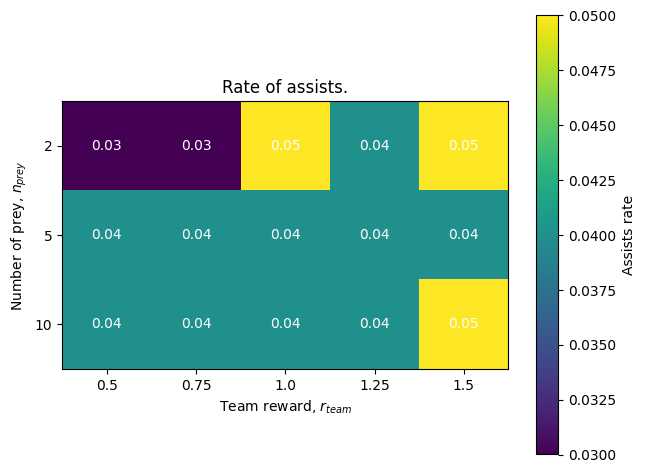

In [43]:
data = runs_summary.copy()
data['nprey'] = data['env_config'].apply(lambda x: json.loads(x)['nprey'])
# REAPLCE WITH eval_assists / eval_kills
data['team_assists_rate'] = data.apply(lambda x: x['episode_assists_mean'] / x['episode_kills_mean'], axis=1)
# data['reward_team'] = 1.0
# REPLACE WITH REAL ENV CONFIG 
data['reward_team'] = data['env_config'].apply(lambda x: json.loads(x)['reward_team'])
ycols_nprey = NPREY
xcols_rteam = R_TEAM

assists_mean = np.zeros((len(ycols_nprey), len(xcols_rteam)))
for i, nprey in enumerate(ycols_nprey):
    for j, rteam in enumerate(xcols_rteam):
        team_assists_rate = data[
            (data['nprey'] == nprey) & 
            (data['reward_team'] == rteam)]['team_assists_rate'].mean()
        if team_assists_rate is None or pd.isna(team_assists_rate):
            team_assists_rate = 0 + abs(np.random.normal(0, 0.1))
        assists_mean[i, j] = round(team_assists_rate, 2)
        
fig, ax = plt.subplots()
im = ax.imshow(assists_mean)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xcols_rteam)), labels=xcols_rteam)
ax.set_yticks(np.arange(len(ycols_nprey)), labels=ycols_nprey)
ax.set_ylabel('Number of prey, $n_{prey}$')
ax.set_xlabel('Team reward, $r_{team}$')

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ycols_nprey)):
    for j in range(len(xcols_rteam)):
        text = ax.text(j, i, assists_mean[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Rate of assists.")
fig.tight_layout()
fig.colorbar(im, ax=ax).set_label('Assists rate')
plt.show()


In [50]:
data = runs_summary.copy()

nprey_list = [5]
rteam_list = [0.5, 1.0, 1.5]
algorithm_types = ['independent', 'shared']

# for a given set of nrpey and rteam, plot training curves
# get new runs for the set of parameters 
for nprey in nprey_list:
    for rteam in rteam_list:
        for algo in algorithm_types:
            subset = api.runs(
                path=f'{ENTITY}/{PROJECT}', 
                filters={
                    "state": "finished",
                    "config.algorithm_type": algo,
                    "config.env_config.nprey": nprey,
                    "config.env_config.reward_team": rteam
                    })
            print(f"""
                    For nprey={nprey}, rteam={rteam}, algo={algo}:
                    {len(subset)} runs
                    """)
            
            # get the training curves for the all runs in the subset 
            for run in subset:
                run_name = run.name
                performance = pd.DataFrame(run._full_history())



                    For nprey=5, rteam=0.5, algo=independent:
                    6 runs
                    

                    For nprey=5, rteam=0.5, algo=shared:
                    7 runs
                    

                    For nprey=5, rteam=1.0, algo=independent:
                    2 runs
                    

                    For nprey=5, rteam=1.0, algo=shared:
                    6 runs
                    

                    For nprey=5, rteam=1.5, algo=independent:
                    5 runs
                    

                    For nprey=5, rteam=1.5, algo=shared:
                    4 runs
                    


In [63]:
file_name_prefix = ""  # _chaser, _fixed, _follower
big_analysis_df = None
algo = 'independent'
nprey = 5
rteam = 1.0
subset = api.runs(
                path=f'{ENTITY}/{PROJECT}', 
                filters={
                    "state": "finished",
                    "config.algorithm_type": algo,
                    "config.env_config.nprey": nprey,
                    "config.env_config.reward_team": rteam
                    })
for run in subset:
    config = run.config
    if file_name_prefix == "":
        file_name_prefix = algo 

    for file in run.files():
        if f"{file_name_prefix}_analysis" in file.name:
            analysis_df = pd.read_json(
                file.download(exist_ok=True), orient="split"
            )
        if f"{file_name_prefix}_eval" in file.name:
            eval_stats = pd.read_json(
                file.download(exist_ok=True), orient="split"
            )
    col_list = (
        analysis_df.groupby(
            ["mode", "agent_a", "agent_b", "test", "dimension"]
        )
        .count()
        .columns
    )
    agg_funcs = []
    for col in col_list:
        if col == "run_id":
            agg_funcs.append((col, "nunique"))
        else:
            agg_funcs.append((col, "mean"))
    analysis_df = (
        analysis_df.groupby(
            ["mode", "agent_a", "agent_b", "test", "dimension"]
        )
        .agg(dict(agg_funcs))
        .reset_index()
    )
    analysis_df["trial_count"] = analysis_df["run_id"]
    analysis_df["run_name"] = run.name
    analysis_df.drop(columns=["run_id"], inplace=True)
    analysis_df["training_episodes_total"] = run.summary["episodes_total"]
    analysis_df["eval_len"] = run.summary["eval_episode_len"]
    analysis_df["eval_assists"] = run.summary["eval_assists"]
    analysis_df["eval_reward"] = run.summary["eval_reward"]
    # analysis_df["analysis_len"] = eval_stats["episode_len"].mean()
    # analysis_df["analysis_reward"] = eval_stats["episode_reward"].mean()
    # analysis_df["analysis_assists"] = eval_stats["assists"].mean()
    big_analysis_df = (
                    pd.concat([big_analysis_df, analysis_df])
                    if big_analysis_df is not None
                    else analysis_df
                )
grouped = big_analysis_df.copy()
grouped = grouped.groupby(["mode", "agent_a", "agent_b", "test", "dimension"])

/tmp/ipykernel_4713/1097762791.py:25: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  eval_stats = pd.read_json(
/tmp/ipykernel_4713/1097762791.py:25: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  eval_stats = pd.read_json(


,mode,agent_a,agent_b,test,dimension,400,1000,2000,trial_count,run_name,training_episodes_total,eval_len,eval_assists,eval_reward
2,independent,predator_0,predator_1,F-p,x,0.514360,0.197467,0.284534,3,df1706244973,1001,95.021771,0.108857,3.363187
2,independent,predator_0,predator_1,F-p,x,0.820343,0.969169,0.972363,3,df1706263013,1002,97.361236,0.091181,3.130543
